## Βασικό χωρικό φιλτράρισμα με χρήση OpenCV

Σε αυτό το notebook θα παρουσιαστούν τα βασικά φίλτρα που χρησιμοποιούνται στην Επεξεργασία Εικόνας για να πετύχουμε βελτίωση της ποιότητας της εικόνας. Συγκεκριμένα θα παρουσιαστούν δύο βασικές κατηγορίες φίλτρων:


1.   Φίλτρα εξομάλυνσης (Χαμηλοπερατά φίλτρα)
2.   Φίλτρα τονισμού αντίθεσης φωτεινοτήτων (υψηλοπερατά φίλτρα)

Στην αρχή θα παρουσιάσουμε τον τρόπο με τον οποίο μπορούμε να υλοποιήσουμε χωρικό φιλτράρισμα χρησιμοποιώντας οποιονδήποτε πυρήνα (kernel) θέλουμε μέσω της opencv και της python.
Κατόπιν, θα δείξουμε τον τρόπο με τον οποίο μπορούμε να υλοποιήσουμε τα φίλτρα box και τα Gaussian φίλτρα για την εξομάλυνση εικόνας και τέλος τα φίλτρα Sobel, Laplacian για την τόνωση των ακμών μιας εικόνας.



In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow #this is used for imshow to work on google colab
from google.colab import drive
import sys
import os

In [2]:
drive.mount('/content/gdrive', force_remount=True)
lib_file_location = "/content/gdrive/My Drive/Courses/TEL 750 - Digital Image Processing/"
sys.path.append(lib_file_location)


Mounted at /content/gdrive


In [3]:
# Resize function

def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim=None
    (h,w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height/float(h)
        dim=(int(w*r),height)
    else:
        r = width/float(w)
        dim = (width, int(r*h))
    return cv2.resize(image, dim, interpolation=inter)

Initial dimensions 300 X 300


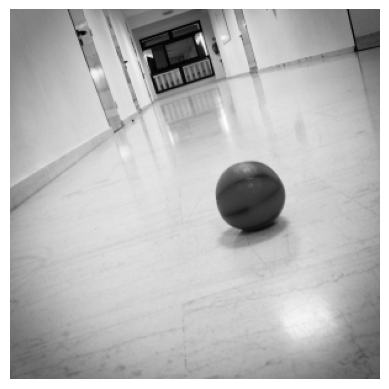

In [28]:
# Read / Show an image
img_file = '/content/gdrive/MyDrive/Courses/TEL 750 - Digital Image Processing/infomm.jpg'
image = cv2.imread(img_file) # this image is in BGR format

# Resize using my own resize function
image = ResizeWithAspectRatio(image, height=300)

# Convert image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print('Initial dimensions', gray_image.shape[0], 'X', gray_image.shape[1])

#cv2_imshow(gray_image)
plt.imshow(gray_image,'gray')
plt.axis('off')
plt.show()



---



---



# Ιστόγραμμα εικόνας

## Υπολογισμός ιστογράμματος

Για τον υπολογισμό του ιστογράμματος μιας εικόνας μπορούμε να χρησιμοποιήσουμε δύο τρόπους:


1.   την συνάρτηση `cv2.calcHist` της opencv
2.   την συνάρτηση `histogram` από την βιβλιοθήκη numpy



In [29]:
hist1 = cv2.calcHist([gray_image],[0],None,[256],[0,256]) # histogram using opencv

hist2,bins = np.histogram(gray_image.ravel(),256,[0,256]) # histogram using numpy

In [30]:
bins

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

## Εμφάνιση ιστογράμματος

Για την εμφάνιση του ιστογράμματος που υπολογίσαμε παραπάνω, μπορούμε να χρησιμοποιήσουμε και πάλι δύο τρόπους:


1.   τις συναρτήσεις της `opencv`
2.   τις γραφικές παραστάσεις που προσφέρει η `numpy`



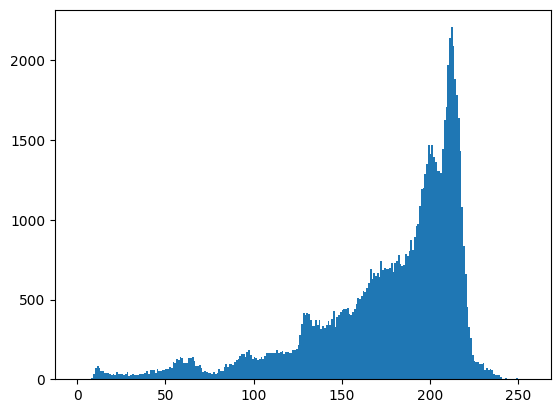

In [31]:
# Χρήση της numpy
plt.hist(gray_image.ravel(),256,[0,256]); # μετατρέπουμε την εικόνα σε μονοδιάστατη
plt.show()


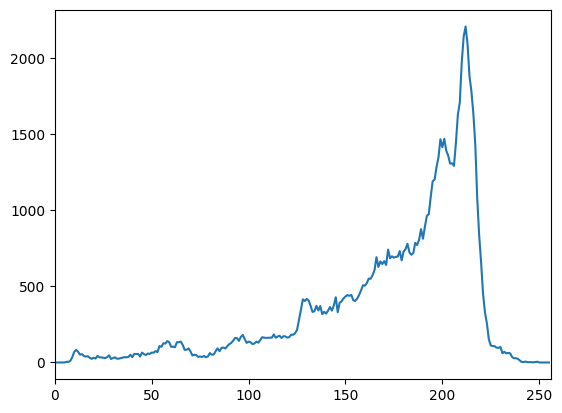

In [32]:
# Χρήση της opencv
plt.plot(hist1)
plt.xlim([0,256])
plt.show()


## Υπολογισμός ιστογράμματος ενός μέρους της εικόνας

Για να υπολογίσουμε το ιστόγραμμα ενός μέρους μιας εικόνας, αυτό που θα πρέπει να κάνουμε είναι να δημιουργήσουμε μια μάσκα η οποία θα επιλέγει το κομμάτι της εικόνας που μας ενδιαφέρει. Αυτό θα πρέπει να το δίνουμε ως εύρος γραμμών και εύρος στηλών (slicing πίνακα).

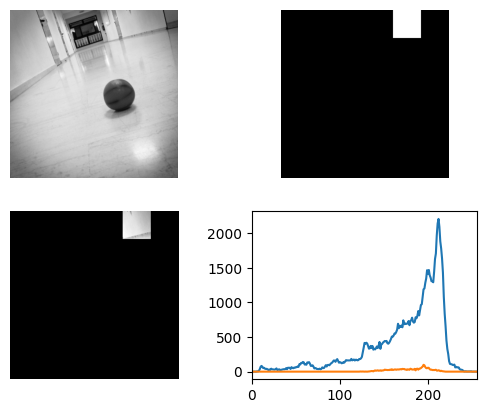

In [54]:
# create a mask
mask = np.ones(gray_image.shape[:2], np.uint8)*0
#mask[150:200, 100:300] = 255
mask[0:50,200:250] = 255

masked_img = cv2.bitwise_and(gray_image,gray_image,mask = mask)

# Calculate histogram with mask and without mask
# Check third argument for mask
hist_full = cv2.calcHist([gray_image],[0],None,[256],[0,256])
hist_mask = cv2.calcHist([masked_img],[0],mask,[256],[0,256])

plt.subplot(221), plt.imshow(gray_image, 'gray')
plt.axis('off')

plt.subplot(222), plt.imshow(mask,'gray')
plt.axis('off')

plt.subplot(223), plt.imshow(masked_img, 'gray')
plt.axis('off')

plt.subplot(224),  plt.plot(hist_full),plt.plot(hist_mask)
plt.xlim([0,256])
plt.show()


## Ισοστάθμιση Ιστογράμματος

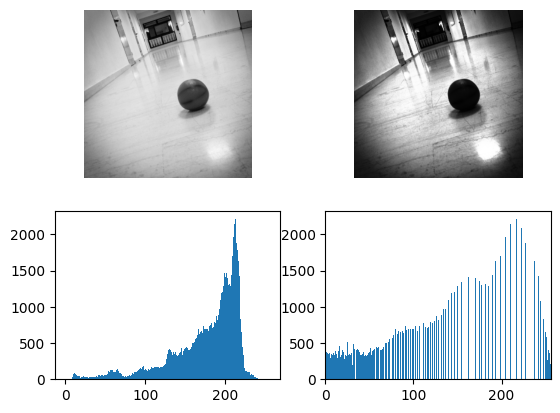

In [34]:
gray_image_eq= cv2.equalizeHist(gray_image)

#hist_before = cv2.calcHist([gray_image],[0],None,[256],[0,256])
#hist_after = cv2.calcHist([gray_image_eq],[0],None,[256],[0,256])

plt.subplot(221), plt.imshow(gray_image, 'gray')
plt.axis('off')

plt.subplot(222), plt.imshow(gray_image_eq,'gray')
plt.axis('off')

plt.subplot(223), plt.hist(gray_image.ravel(),256,[0,256]);
plt.subplot(224), plt.hist(gray_image_eq.ravel(),256,[0,256]);
plt.xlim([0,256])
plt.show()

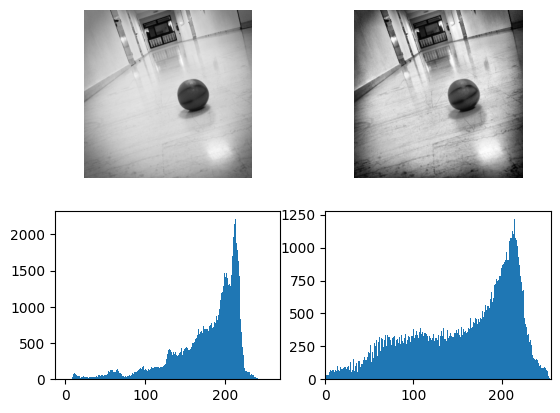

In [59]:
# Ισοστάθμιση ιστογράμματος με την μέθοδο CLAHE (τοπική ισοστάθμιση ιστογράμματος)

# create a CLAHE object (Arguments optional).
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(5,5))
cl1 = clahe.apply(gray_image)


plt.subplot(221), plt.imshow(gray_image, 'gray')
plt.axis('off')

plt.subplot(222), plt.imshow(cl1,'gray')
plt.axis('off')

plt.subplot(223), plt.hist(gray_image.ravel(),256,[0,256]);
plt.subplot(224), plt.hist(cl1.ravel(),256,[0,256]);
plt.xlim([0,256])
plt.show()

## Histogram Matching

Για να πετύχουμε το ταίριασμα ιστογράμματος, θα πρέπει να χρησιμοποιήσουμε την συνάρτηση `match_histograms` η οποία ανήκει στην βιβλιοθήκη exposure του scikit-image πακέτου. Σε αυτή δεν δίνουμε το ιστόγραμμα που επιθυμούμε, αλλά την εικόνα (`destination`) της οποίας το ιστόγραμμα θέλουμε να πετύχουμε στην δική μας εικόνα (`source`). Η εικόνα που προκύπτει ως αποτέλεσμα, βρίσκεται στον πίνακα `matched`.

In [62]:
# Load the target image
# Read / Show an image
target_img_file = '/content/gdrive/MyDrive/Courses/TEL 750 - Digital Image Processing/nephelim2.png'
target_image = cv2.imread(target_img_file) # this image is in BGR format

# Resize using my own resize function
target_image = ResizeWithAspectRatio(target_image, height=300)

# Convert image to grayscale
gray_target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)
print('Initial dimensions', gray_target_image.shape[0], 'X', gray_target_image.shape[1])

#cv2_imshow(gray_image)
plt.imshow(gray_target_image,'gray')
plt.axis('off')
plt.show()

AttributeError: 'NoneType' object has no attribute 'shape'

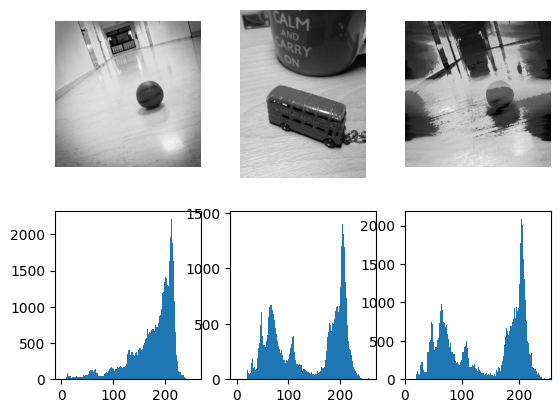

In [49]:
from skimage import exposure

matched = exposure.match_histograms(gray_image, gray_target_image, channel_axis=0)

hist_source = cv2.calcHist([gray_image],[0],None,[256],[0,256])
hist_dest = cv2.calcHist([gray_target_image],[0],None,[256],[0,256])
hist_matched = cv2.calcHist([gray_image_eq],[0],None,[256],[0,256])

plt.subplot(231), plt.imshow(gray_image, 'gray')
plt.axis('off')

plt.subplot(232), plt.imshow(gray_target_image,'gray')
plt.axis('off')

plt.subplot(233), plt.imshow(matched,'gray')
plt.axis('off')

plt.subplot(234), plt.hist(gray_image.ravel(),256,[0,256]);
plt.subplot(235), plt.hist(gray_target_image.ravel(),256,[0,256]);
plt.subplot(236), plt.hist(matched.ravel(),256,[0,256]);
plt.xlim([0,256])
plt.show()

# Επέκταση εικόνας (χρησιμοποιείται στο χωρικό φιλτράρισμα)

## Προσθήκη περιγράμματος σταθερής φωτεινότητας

New dimensions 330 X 330


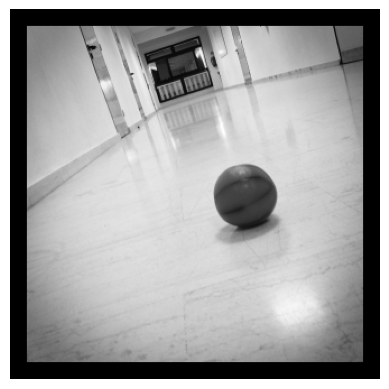

In [40]:
gray_image1 = cv2.copyMakeBorder(gray_image,15, 15, 15, 15, cv2.BORDER_CONSTANT, value=0)
print('New dimensions', gray_image1.shape[0], 'X', gray_image1.shape[1])

#cv2_imshow(gray_image1)
plt.imshow(gray_image1,'gray')
plt.axis('off')
plt.show()

## Προσθήκη περιγράμματος με αντιγραφή των άκρων της εικόνας

New dimensions 324 X 324


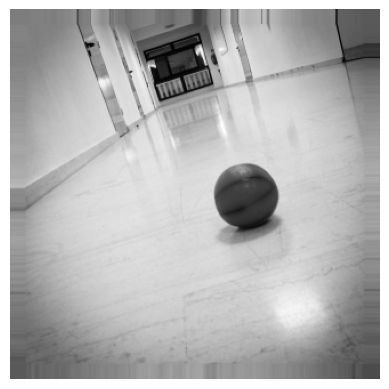

In [41]:
gray_image2 = cv2.copyMakeBorder(gray_image, 12, 12, 12, 12, cv2.BORDER_REPLICATE)
print('New dimensions', gray_image2.shape[0], 'X', gray_image2.shape[1])

#cv2_imshow(gray_image2)
plt.imshow(gray_image2,'gray')
plt.axis('off')
plt.show()


## Προσθήκη περιγράμματος με κατοπτρισμό των άκρων της εικόνας

New dimensions 330 X 330


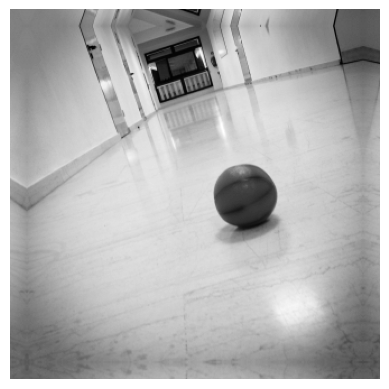

In [42]:
gray_image3 = cv2.copyMakeBorder(gray_image, 15, 15, 15, 15, cv2.BORDER_REFLECT)
print('New dimensions', gray_image3.shape[0], 'X', gray_image3.shape[1])

#cv2_imshow(gray_image3)
plt.imshow(gray_image3,'gray')
plt.axis('off')
plt.show()

# Χωρικό φιλτράρισμα με χρήση πυρήνα

Σε αυτό το παράδειγμα χρησιμοποιούμε πυρήνα μεγέθους 5Χ5 με τιμές ίσες με 1/25. Στην ουσία πρόκειται για ένα φίλτρο εξομάλυνσης (box filter), αλλά στην θέση του μπορούμε να αντικαταστήσουμε με οποιονδήποτε πυρήνα θέλουμε.

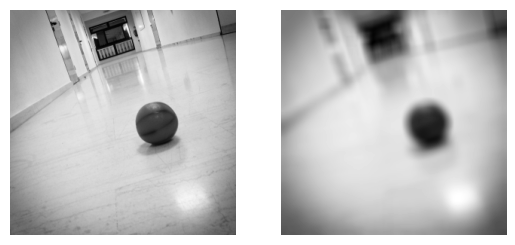

In [43]:
kernel = np.ones((15,15),np.float32)/(15*15) #this is a smoothing filter
filtered_img = cv2.filter2D(src=gray_image, ddepth=-1, kernel = kernel,borderType=cv2.BORDER_REFLECT)

#res = np.hstack((gray_image, filtered_img))
#cv2_imshow(res)
plt.subplot(121), plt.imshow(gray_image,'gray')
plt.axis('off')
plt.subplot(122), plt.imshow(filtered_img,'gray')
plt.axis('off')
plt.show()

## Εξομάλυνση με χρήση box filter

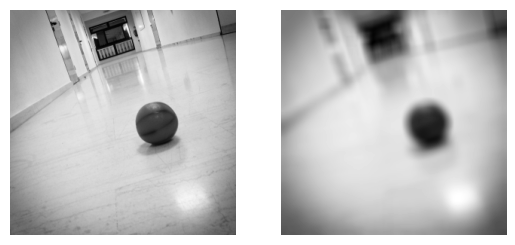

In [44]:
blur = cv2.blur(src=gray_image, ksize=(15,15),borderType=cv2.BORDER_REFLECT)

#res = np.hstack((gray_image, blur))
#cv2_imshow(res)
plt.subplot(121), plt.imshow(gray_image,'gray')
plt.axis('off')

plt.subplot(122), plt.imshow(blur,'gray')
plt.axis('off')

plt.show()

## Εξομάλυνση με χρήση μη-κανονικοποιημένου φίλτρου box

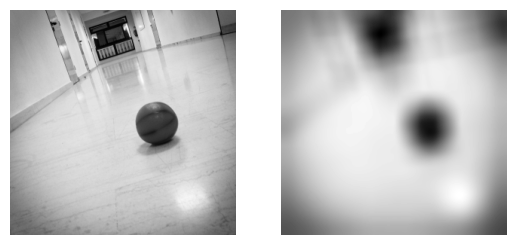

In [45]:
box = cv2.boxFilter(src=gray_image, ddepth=-1,ksize=(35,35), normalize=True, borderType=cv2.BORDER_REFLECT)

#res = np.hstack((gray_image, box))
#cv2_imshow(res)
plt.subplot(121), plt.imshow(gray_image,'gray')
plt.axis('off')

plt.subplot(122), plt.imshow(box,'gray')
plt.axis('off')

plt.show()


array([[128, 128, 128, ...,  92,  92,  92],
       [128, 128, 128, ...,  92,  92,  92],
       [128, 128, 128, ...,  92,  92,  92],
       ...,
       [103, 103, 103, ...,  94,  94,  94],
       [103, 103, 103, ...,  94,  94,  94],
       [103, 103, 103, ...,  94,  94,  94]], dtype=uint8)
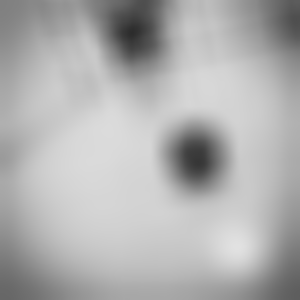

In [46]:
box

## Χωρικό φιλτράρισμα εξομάλυνσης με χρήση Gaussian φίλτρου

Στο παρακάτω κομμάτι κώδικα, παρατηρήστε ότι μπορούμε να επιλέξουμε το μέγεθος του πυρήνα καθώς και την διασπορά της gaussian συνάρτησης τόσο στον άξονα x (γραμμές) όσο και στον άξονα y (στήλες). Θυμίζουμε από την θεωρία ότι το μέγιστο μέγεθος του πυρήνα για την εξομάλυνση με Gaussian φίλτρο δεν ξεπερνάει το 6σ Χ 6σ (σ είναι η διασπορά σε κάθε κατεύθυνση). Οποιοδήποτε μέγεθος μεγαλύτερο από το παραπάνω, δεν προσθέτει κάτι στην απόδοση του φίλτρου, παρά μόνο υπολογιστική πολυπλοκότητα.

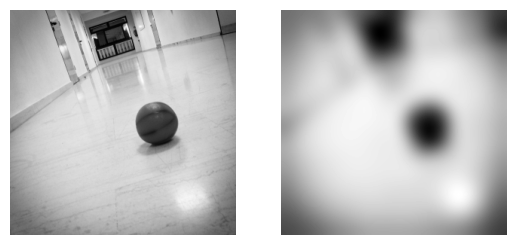

In [47]:
gaussian_blur = cv2.GaussianBlur(src=gray_image, ksize=(51,51), sigmaX=12, sigmaY=12,borderType=cv2.BORDER_REFLECT)

#res = np.hstack((gray_image, gaussian_blur))
#cv2_imshow(res)
plt.subplot(121), plt.imshow(gray_image,'gray')
plt.axis('off')

plt.subplot(122), plt.imshow(gaussian_blur,'gray')
plt.axis('off')

plt.show()

# Φίλτρα τόνωσης της όξυνσης εικόνας

Στην κατηγορία αυτή ανήκουν φίλτρα τα οποία υπολογίζουν την μεταβολή φωτεινοτήτων στους άξονες της εικόνας. Για τον λόγο αυτό χρησιμοποιούν στους υπολογισμούς τους τις παραγώγους πρώτης ή δεύτερης τάξης.

## Φίλτρα Sobel (πρώτης τάξης παράγωγοι)

Τα φίλτρα αυτά χρησιμοποιούν πυρήνα μεγέθους 3Χ3 για να υπολογίσουν ξεχωριστά τις μεταβολές φωτεινότητας κατά γραμμές και κατά στήλες της εικόνας. Ο συνδυασμός τους θα μας δώσει μια νέα εικόνα με ενισχυμένες τις ακμές και στις δύο διαστάσεις.

In [ ]:
sobelx = cv2.Sobel(src=gray_image, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
sobely = cv2.Sobel(src=gray_image, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)
sobelxy = cv2.Sobel(src=gray_image, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=3)

#res = np.hstack((gray_image, sobelx, sobely, sobelxy))
#cv2_imshow(res)
plt.subplot(221), plt.imshow(gray_image,'gray')
plt.subplot(222), plt.imshow(sobelx,'gray')
plt.subplot(223), plt.imshow(sobely,'gray')
plt.subplot(224), plt.imshow(sobelxy,'gray')


In [ ]:
sobelxy.max()

## Laplacian φίλτρα

Τα φίλτρα αυτά χρησιμοποιούν παραγώγους δεύτερης τάξης για τον υπολογισμό των διαφορών των φωτεινοτήτων της εικόνας

In [ ]:
# Laplacian filter
laplacian_img = cv2.Laplacian(src=gray_image, ddepth = cv2.CV_16S)
abs_dst = cv2.convertScaleAbs(laplacian_img)

#res = np.hstack((gray_image, laplacian_img))
#cv2_imshow(res)
plt.subplot(121), plt.imshow(gray_image,'gray')
plt.subplot(122), plt.imshow(laplacian_img,'gray')

# Unsharp masking & HighBoost filtering

Η τεχνική αυτή μας επιτρέπει να οξύνουμε μια εικόνα χρησιμοποιώντας όμως φίλτρο εξομάλυνσης. Αυτό γίνεται σε δύο βήματα:
1.   Αρχικά εξομαλύνουμε την εικόνα χρησιμοποιώντας ένα Gaussian φίλτρο. Έτσι διώχνουμε τις υψηλές συχνότητες της εικόνας.
2.   Αφαιρούμε αυτήν την θολωμένη εικόνα από την αρχική μας και δημιουργούμε την μάσκα. Η εικόνα που προκύπτει θα έχει τις περισσότερες υψηλές συχνότητες που έχουμε βγάλει από την εξομαλυμένη
3. Προσθέτουμε την μάσκα πάλι πίσω στην αρχική (πολλαπλασιασμένη με κάποιον συντελεστή) ώστε να ενισχύσουμε τις υψηλές συχνότητες.

Αν η αρχική μας εικόνα περιέχει θόρυβο, η τεχνική αυτή δεν θα έχει καλά αποτελέσματα.




In [ ]:
# Blur the image
gauss = cv2.GaussianBlur(gray_image, (7,7), 0)
# Apply Unsharp masking

k=5
unsharp_image = cv2.addWeighted(gray_image, k+1, gauss, -k, 0)

#res = np.hstack((gray_image, unsharp_image))
#cv2_imshow(res)
plt.subplot(121), plt.imshow(gray_image,'gray')
plt.subplot(122), plt.imshow(unsharp_image,'gray')

